In [1]:
# section 1:  import Libraries 

In [2]:

import requests # this libraray helps to fetch data from API 
import pandas as pd # for handling and analysing data 
import numpy as np # fro numberical operations 
from sklearn.model_selection import train_test_split # to split data into training and testing 
from sklearn.preprocessing import LabelEncoder # to convert catogerical data into numerical values 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # modles fro classification and regression 
from sklearn.metrics import mean_squared_error # to measure the accuracy of our predications 
from datetime import datetime,timedelta # to handle data and time 
from sklearn.metrics import  accuracy_score,precision_score,recall_score
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pytz
import warnings
warnings.filterwarnings('ignore')


In [3]:
API_KEY ='1fb3adef2be18083bf8ab4be69ba4875' #actual api key 
BASE_URL ='https://api.openweathermap.org/data/2.5/' # base url for main api reuqests

1 . fetch current weather data 

In [4]:
def get_current_weather(city):
    url =f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    data = response.json()

    return {
        'description': data['weather'][0]['description'],
        'country': data['sys']['country'],
        'wind_gust_dir': data['wind'].get('deg', 0),
        'pressure': data['main']['pressure'],
        'Wind_Gust_Speed': data['wind'].get('speed', 0),
        'humidity': data['main']['humidity'],
        'current_temp': data['main']['temp'],
        'temp_min': data['main']['temp_min'],
        'temp_max': data['main']['temp_max'],
        'feels_like': data['main']['feels_like'],
        
    }


2. Read Historical Data

In [5]:
def read_historical_data(filename):
    df=pd.read_csv(filename) # learn csv file into dataframe
    df=df.dropna() # remove with missing values
    df=df.drop_duplicates()
    return df

3. Preapre data from Training 

In [6]:
from sklearn.preprocessing import LabelEncoder

def prepare_data(data):
    le = LabelEncoder()

    #data = data.copy()  # avoid modifying original

    data['WindGustDir'] = le.fit_transform(data['WindGustDir'].astype(str)) #Converts wind direction (N, NE, SW, etc.) → numeric values

    data['RainTomorrow'] = le.fit_transform(data['RainTomorrow'].astype(str))#Converts RainTomorrow (Yes/No) → 1/0

    X = data.drop('RainTomorrow', axis=1)
    y = data['RainTomorrow']

    return X, y, le


4 . Train Rain Prediction Model

In [7]:
def train_rain_model(x,y):

    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)

    model =RandomForestClassifier(n_estimators=100,random_state=42)
    model.fit(x_train,y_train) # train the model

    y_pred =model.predict(x_test) # to make prediction on test set
    
    #model evaluation(classification)

    accuracy=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)

    print("\nrain predication model performance")
    print("Accuracy :",round(accuracy,2))
    print("precision :",round(precision,2))
    print("Recall :",round(recall,2))
    return model

5 . Preapre Regression Data

In [8]:
def prepare_regression_data(data,feature):
    x, y = [], []  # lists

    for i in range(len(data) - 1):
        x.append(data[feature].iloc[i])
        y.append(data[feature].iloc[i + 1])

    # convert AFTER loop
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)

    return x, y
   

6. Train Regression Model

In [9]:
def train_regression_model(x,y):
    model=RandomForestRegressor(n_estimators=100,random_state=42)
    model.fit(x,y)

    #regression evaluations
    y_pred =model.predict(x)

    mae = mean_absolute_error(y,y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))


    print("\nRegression model performance")
    print("MAE :",round(mae,))
    print("RMSE :",round(rmse ,))
    
    return model

Predict Future 

In [10]:
def predict_future(model,current_value):
    predictions =[current_value] #Starts with current value.
    
    for i in range(5):
        next_value =model.predict(np.array([[predictions[-1]]]))  # Predicts next 5 future values
        
        predictions.append(next_value[0])
    return predictions[1:]  #Returns only future values

Recommendation Logic

In [11]:
def recommend_activity(temp, rain, humidity):
    if rain == 1:
        return "Indoor activities (Reading, Movies, Home workout)"
    
    elif temp < 15:
        return "Warm indoor plans (Hot drinks, Blanket time, Light exercise)"
    
    elif 15 <= temp <= 25:
        if humidity > 70:
            return "Light outdoor (Evening walk, Gardening)"
        else:
            return "Outdoor activities (Jogging, Cycling, Sports)"
    
    else:  # temp > 25
        return "Light outdoor (Morning walk, Short outings, Hydration needed)"


Interpret Results 

In [12]:
def interpret_results(weather, rain_pred, future_temp, future_humidity):
    print("\n--- Interpretation & Insights (Model Understanding) ---")

    # Explain rain prediction
    if rain_pred == 1:
        print("• The model detected weather patterns similar to rainy conditions.")
    else:
        print("• The model found low probability of rainfall based on current features.")

    # Explain temperature condition
    print(f"• Current temperature ({weather['current_temp']}°C) influences comfort level.")

    # Explain humidity effect
    print(f"• Humidity level ({weather['humidity']}%) affects how hot or cold it feels.")

    # Explain future trend
    if future_temp[-1] > future_temp[0]:
        print("• Temperature trend shows an increasing pattern in upcoming hours.")
    else:
        print("• Temperature trend is stable or decreasing in upcoming hours.")

    if future_humidity[-1] > future_humidity[0]:
        print("• Humidity is expected to rise, which may increase discomfort.")
    else:
        print("• Humidity is expected to remain stable or decrease.")

    print("• These insights help understand model behavior beyond raw predictions.")


In [13]:
import matplotlib.pyplot as plt

def plot_future_temperature(times, future_temp):
    plt.figure()
    plt.plot(times, future_temp, marker='o')
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.title("Future Temperature Prediction")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [14]:
def plot_future_humidity(times, future_humidity):
    plt.figure()
    plt.plot(times, future_humidity, marker='o')
    plt.xlabel("Time")
    plt.ylabel("Humidity (%)")
    plt.title("Future Humidity Prediction")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


8.Weather Analysis Functions 


rain predication model performance
Accuracy : 0.85
precision : 0.86
Recall : 0.38

Temperature

Regression model performance
MAE : 2
RMSE : 2

Humidity

Regression model performance
MAE : 10
RMSE : 13


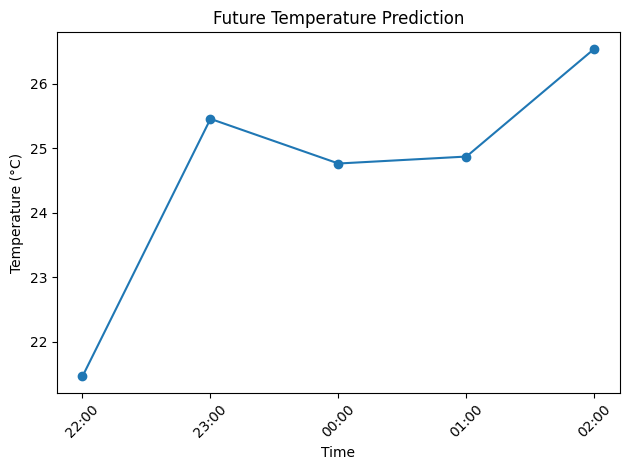

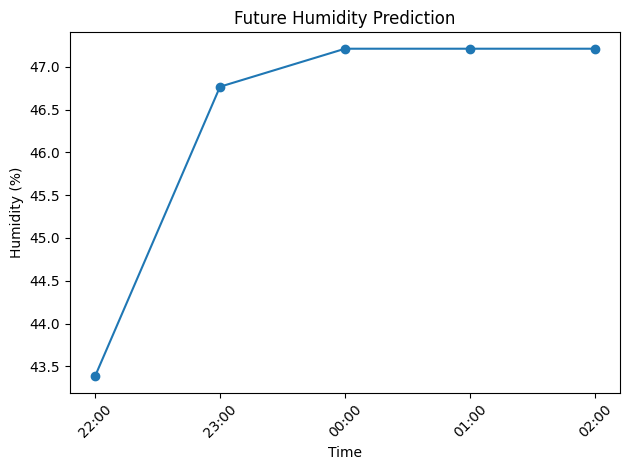


--- Interpretation & Insights (Model Understanding) ---
• The model detected weather patterns similar to rainy conditions.
• Current temperature (22.61°C) influences comfort level.
• Humidity level (52%) affects how hot or cold it feels.
• Temperature trend shows an increasing pattern in upcoming hours.
• Humidity is expected to rise, which may increase discomfort.
• These insights help understand model behavior beyond raw predictions.

city :pune,IN

current Temperature :22.61
feels like:22.28
minimum Temperature:22.61°C
maximum Temperature:22.61°C

humidity :52

wind speed :2.88m/s
Wind direction:W
Weather Predication :few clouds

Rain Predication:Yes

Recommended Activity : Indoor activities (Reading, Movies, Home workout)

Future Temperautre Predications :
 22:00: 21.5°C
 23:00: 25.5°C
 00:00: 24.8°C
 01:00: 24.9°C
 02:00: 26.5°C

Future humidity Predications :
 22:00:43.4%
 23:00:46.8%
 00:00:47.2%
 01:00:47.2%
 02:00:47.2%


In [15]:
def weather_view():
    city=input("Enter any city name :")
    current_weather =get_current_weather(city)
    
    #load historical data
    
    historical_data=read_historical_data(r"C:\Aparaitech\Project_1\weather.csv")
    
    #prepare and train the rain predication model 
    
    x,y,le=prepare_data(historical_data)
    
    rain_model =train_rain_model(x,y)
    
    # map wind direction to campass modle
    
# map wind direction to compass points
    wind_deg = current_weather['wind_gust_dir'] % 360

    compass_points = [
    ("N", 0, 11.25), ("NNE", 11.25, 33.75), ("NE", 33.75, 56.25),
    ("ENE", 56.25, 78.75), ("E", 78.75, 101.25), ("ESE", 101.25, 123.75),
    ("SE", 123.75, 146.25), ("SSE", 146.25, 168.75), ("S", 168.75, 191.25),
    ("SSW", 191.25, 213.75), ("SW", 213.75, 236.25), ("WSW", 236.25, 258.75),
    ("W", 258.75, 281.25), ("WNW", 281.25, 303.75), ("NW", 303.75, 326.25),
    ("NNW", 326.25, 348.75)
    ]

    compass_direction = next(
    point for point, start, end in compass_points
    if start <= wind_deg < end
    )

    compass_direction_encoded =le.transform([compass_direction])[0] if compass_direction in le.classes_ else -1 
    

    current_data ={
        'MinTemp' : current_weather['temp_min'],
        'MaxTemp' : current_weather['temp_max'],
        'WindGustDir':compass_direction_encoded,
        'WindGustSpeed':current_weather['Wind_Gust_Speed'],
        'Humidity':current_weather['humidity'],
        'Pressure':current_weather['pressure'],
        'Temp': current_weather['current_temp'],
    
    }
    
    current_df=pd.DataFrame([current_data])
    
    # rain predications 
    
    rain_predication =rain_model.predict(current_df)[0]
    
    #prepare regression model fro temp and humidity 
    
    x_temp,y_temp = prepare_regression_data(historical_data,'Temp')
    
    x_hum,y_hum =prepare_regression_data(historical_data,'Humidity')
    print("\nTemperature")
    temp_model =train_regression_model(x_temp,y_temp)
    print("\nHumidity")
    hum_model =train_regression_model(x_hum,y_hum)


    # predict future temp and humidity
    
    future_temp =predict_future(temp_model,current_weather['temp_min'])
 
    future_humidity=predict_future(hum_model,current_weather['humidity'])    
    
    #prepare time for future predictaions 
    
    timezone =pytz.timezone('Asia/Karachi')
    now =datetime.now(timezone)
    next_hour=now+timedelta(hours=1)
    next_hour=next_hour.replace(minute=0,second=0,microsecond=0)
    
    future_times =[(next_hour+timedelta(hours=i)).strftime("%H:00") for i in range(5)]
     
    plot_future_temperature(future_times, future_temp)
    plot_future_humidity(future_times, future_humidity)

    
    activity = recommend_activity(
        temp=current_weather['current_temp'],
        rain=rain_predication,
        humidity=current_weather['humidity']
    )

    interpret_results(
        weather=current_weather,
        rain_pred=rain_predication,
        future_temp=future_temp,
        future_humidity=future_humidity
    )

        
    #display results 
    
    print(f"\ncity :{city},{current_weather['country']}\n")
    print(f"current Temperature :{current_weather['current_temp']}")
    print(f"feels like:{current_weather['feels_like']}")
    print(f"minimum Temperature:{current_weather['temp_min']}°C")
    print(f"maximum Temperature:{current_weather['temp_max']}°C\n")
    print(f"humidity :{current_weather['humidity']}\n")
    print(f"wind speed :{current_weather['Wind_Gust_Speed']}m/s")
    print(f"Wind direction:{compass_direction}")
    print(f"Weather Predication :{current_weather['description']}\n")
    print(f"Rain Predication:{'Yes' if rain_predication else 'No'}")
    
    print(f"\nRecommended Activity : {activity}")

    print('\nFuture Temperautre Predications :')
    
    for time,temp in zip(future_times,future_temp):
        print(f" {time}: {round(temp,1)}°C")
        
    print('\nFuture humidity Predications :')
    
    for time,humidity in zip(future_times,future_humidity):
        print(f" {time}:{round(humidity,1)}%")      
weather_view()